In [1]:
# Lab 10 MNIST and softmax
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pylab as plt

In [2]:
# Select Target Device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# for reproducibility
torch.manual_seed(1)
if device == 'cuda':
    torch.cuda.manual_seed_all(1)

In [3]:
# parameters
learning_rate = 0.01
training_epochs = 10
batch_size = 32

In [4]:
# MNIST dataset
mnist_train = dsets.MNIST(root='../MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='../MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

In [5]:
# dataset loader
train_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           drop_last=True)
test_loader = torch.utils.data.DataLoader(dataset=mnist_test,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          drop_last=True)

In [6]:
# Network Architexture
linear1 = torch.nn.Linear(784, 32, bias=True)
linear2 = torch.nn.Linear(32, 32, bias=True)
linear3 = torch.nn.Linear(32, 10, bias=True)
relu = torch.nn.ReLU()
bn1 = torch.nn.BatchNorm1d(32)
bn2 = torch.nn.BatchNorm1d(32)

nlinear1 = torch.nn.Linear(784, 32, bias=True)
nlinear2 = torch.nn.Linear(32, 32, bias=True)
nlinear3 = torch.nn.Linear(32, 10, bias=True)

In [7]:
#model
bn_model = torch.nn.Sequential(linear1, bn1, relu,
                               linear2, bn2, relu,
                               linear3).to(device)
nn_model = torch.nn.Sequential(nlinear1,relu,
                               nlinear2,relu,
                               nlinear3).to(device)

In [8]:
# define cost/loss & optimizer
criterion = torch.nn.CrossEntropyLoss().to(device)    # Softmax is internally computed.
bn_optimizer = torch.optim.Adam(bn_model.parameters(), lr=learning_rate)
nn_optimizer = torch.optim.Adam(nn_model.parameters(), lr=learning_rate)

In [15]:
train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

train_total_batch = len(train_loader)
test_total_batch = len(test_loader)
for epoch in range(training_epochs):
    bn_model.train()
    
    for X,Y in train_loader:
        # reshape input image into [Batch_size by 784]
        # label is not one-hot encoded
        X = X.view(-1, 28*28).to(device)
        Y = Y.to(device)
        
        bn_optimizer.zero_grad()
        bn_hypothesis = bn_model(X)
        bn_cost = criterion(bn_hypothesis,Y)
        bn_cost.backward()
        bn_optimizer.step()
        
        nn_optimizer.zero_grad()
        nn_hypothesis = nn_model(X)
        nn_cost = criterion(nn_hypothesis,Y)
        nn_cost.backward()
        nn_optimizer.step()
    with torch.no_grad():
        bn_model.eval()
        
        # Test the model using train sets
        bn_loss, nn_loss, bn_acc, nn_acc = 0,0,0,0
        for i, (X, Y) in enumerate(train_loader):
            X = X.view(-1,28*28).to(device)
            Y = Y.to(device)
            
            bn_prediction = bn_model(X)
            bn_cp = torch.argmax(bn_prediction,1)==Y
            bn_loss += criterion(bn_prediction,Y)
            bn_acc += bn_cp.float().mean()
            
            nn_prediction = nn_model(X)
            nn_cp = torch.argmax(nn_prediction,1)==Y
            nn_loss += criterion(nn_prediction,Y)
            nn_acc += nn_cp.float().mean()
        bn_loss = bn_loss/train_total_batch
        nn_loss = nn_loss/train_total_batch
        bn_acc  = bn_acc/train_total_batch
        nn_acc  = nn_acc/train_total_batch
        
        # Save train losses/acces
        train_losses.append([bn_loss,nn_loss])
        train_accs.append([bn_acc,nn_acc])
        print('[E.%2d-Train] Bn Loss : %.5f / Bn acc %.2f / nn Loss %.5f / nn acc %.2f' %
             ((epoch+1),
              bn_loss.item(),bn_acc.item(),
              nn_loss.item(),nn_acc.item()))
        
        
        # Test the model using test sets
        bn_loss, nn_loss, bn_acc, nn_acc = 0,0,0,0
        for i, (X, Y) in enumerate(test_loader):
            X = X.view(-1,28*28).to(device)
            Y = Y.to(device)
            
            bn_prediction = bn_model(X)
            bn_cp = torch.argmax(bn_prediction,1)==Y
            bn_loss += criterion(bn_prediction,Y)
            bn_acc += bn_cp.float().mean()
            
            nn_prediction = nn_model(X)
            nn_cp = torch.argmax(nn_prediction,1)==Y
            nn_loss += criterion(nn_prediction,Y)
            nn_acc += nn_cp.float().mean()
        bn_loss = bn_loss/train_total_batch
        nn_loss = nn_loss/train_total_batch
        bn_acc  = bn_acc/train_total_batch
        nn_acc  = nn_acc/train_total_batch
        
        # Save valid losses/acces
        valid_losses.append([bn_loss,nn_loss])
        valid_accs.append([bn_acc,nn_acc])
        print('[E.%2d-Valid] Bn Loss : %.5f / Bn acc %.2f / nn Loss %.5f / nn acc %.2f' %
             ((epoch+1),
              bn_loss.item(),bn_acc.item(),
              nn_loss.item(),nn_acc.item()))
        print()
print('Learning finished')

[E. 1-Train] Bn Loss : 0.06462 / Bn acc 0.98 / nn Loss 0.13462 / nn acc 0.96
[E. 1-Valid] Bn Loss : 0.01666 / Bn acc 0.16 / nn Loss 0.02997 / nn acc 0.16

[E. 2-Train] Bn Loss : 0.06144 / Bn acc 0.98 / nn Loss 0.14530 / nn acc 0.96
[E. 2-Valid] Bn Loss : 0.01663 / Bn acc 0.16 / nn Loss 0.03239 / nn acc 0.16

[E. 3-Train] Bn Loss : 0.05598 / Bn acc 0.98 / nn Loss 0.12942 / nn acc 0.96
[E. 3-Valid] Bn Loss : 0.01678 / Bn acc 0.16 / nn Loss 0.03012 / nn acc 0.16

[E. 4-Train] Bn Loss : 0.05029 / Bn acc 0.98 / nn Loss 0.14320 / nn acc 0.96
[E. 4-Valid] Bn Loss : 0.01506 / Bn acc 0.16 / nn Loss 0.03313 / nn acc 0.16

[E. 5-Train] Bn Loss : 0.05077 / Bn acc 0.98 / nn Loss 0.11385 / nn acc 0.97
[E. 5-Valid] Bn Loss : 0.01522 / Bn acc 0.16 / nn Loss 0.02861 / nn acc 0.16

[E. 6-Train] Bn Loss : 0.05009 / Bn acc 0.98 / nn Loss 0.11077 / nn acc 0.97
[E. 6-Valid] Bn Loss : 0.01664 / Bn acc 0.16 / nn Loss 0.02911 / nn acc 0.16

[E. 7-Train] Bn Loss : 0.04221 / Bn acc 0.99 / nn Loss 0.12414 / nn ac

In [16]:
def plot_compare(loss_list: list, ylim=None, title=None) -> None:
    bn = [i[0] for i in loss_list]
    nn = [i[1] for i in loss_list]

    plt.figure(figsize=(15, 10))
    plt.plot(bn, label='With BN')
    plt.plot(nn, label='Without BN')
    if ylim:
        plt.ylim(ylim)

    if title:
        plt.title(title)
    plt.legend()
    plt.grid('on')
    plt.show()

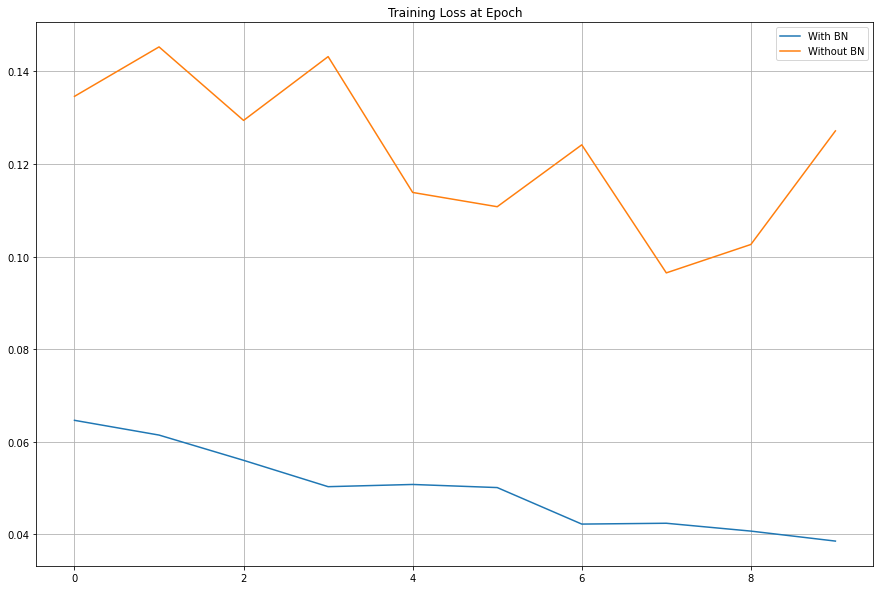

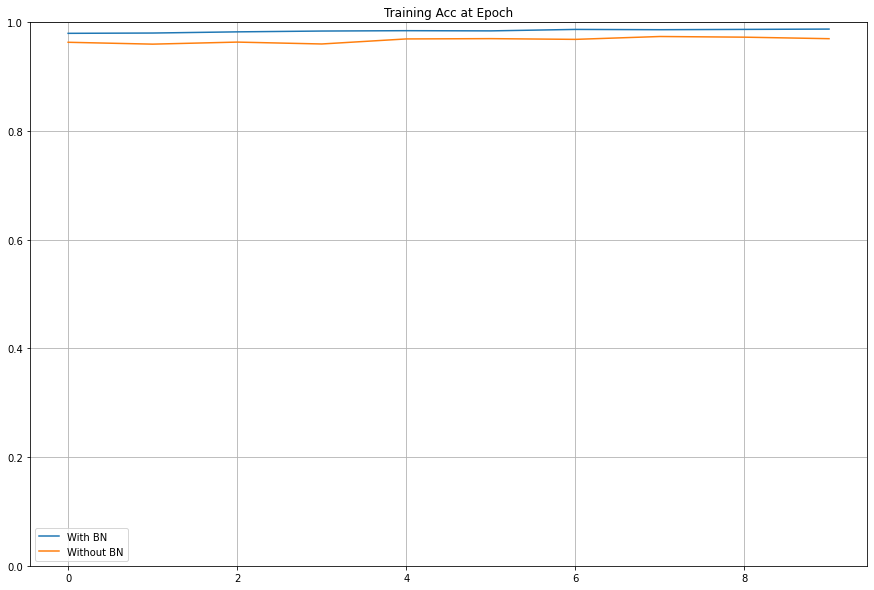

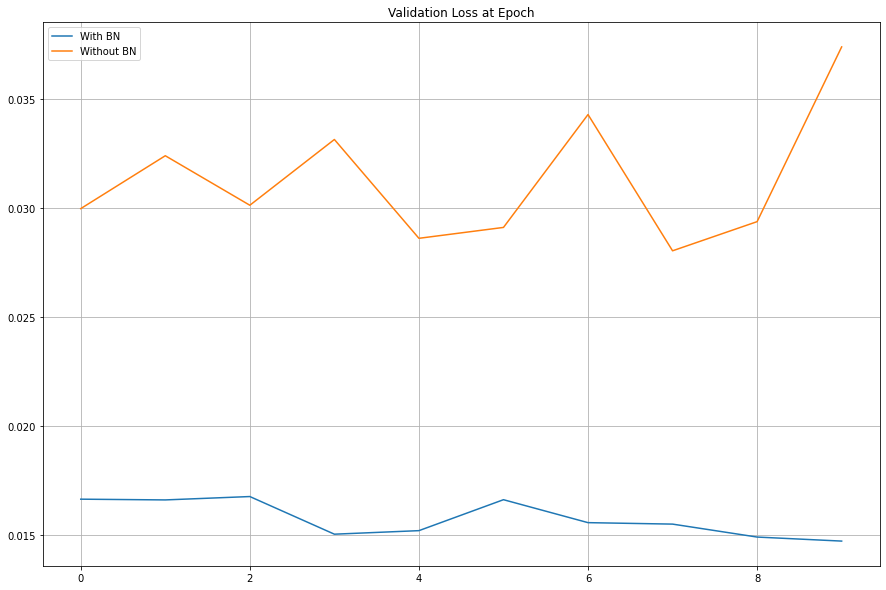

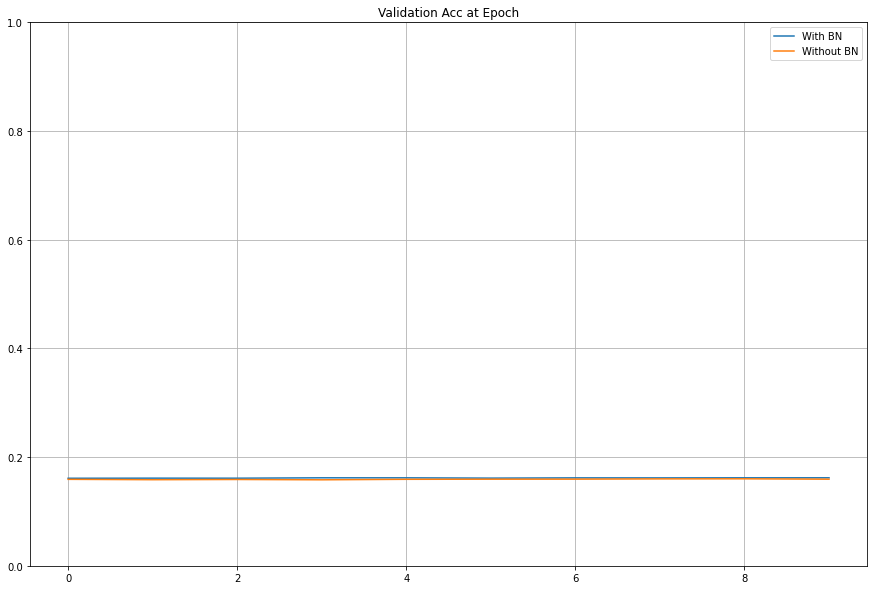

In [17]:
plot_compare(train_losses, title='Training Loss at Epoch')
plot_compare(train_accs, [0, 1.0], title='Training Acc at Epoch')
plot_compare(valid_losses, title='Validation Loss at Epoch')
plot_compare(valid_accs, [0, 1.0], title='Validation Acc at Epoch')